In [17]:
# import the required libraries
from czitools import pylibczirw_metadata as czimd
from czitools import pylibczirw_tools as czird
from czitools import misc, napari_tools
from ipyfilechooser import FileChooser
from IPython.display import display, HTML
import napari
from pathlib import Path
import os
import dask.array as da

In [2]:
defaultdir = os.path.join(Path(os.getcwd()).resolve().parents[1], "data")
fc = FileChooser(defaultdir)
fc.filter_pattern = '*.czi'
display(fc)

FileChooser(path='F:\Github\czitools\data', filename='', title='', show_hidden=False, select_desc='Select', ch…

In [3]:
# Print the selected path, filename, or both
print(fc.selected_path)
print(fc.selected_filename)
print(fc.selected)

F:\Github\czitools\data
CellDivision_T=3_Z=5_CH=2_X=240_Y=170.czi
F:\Github\czitools\data\CellDivision_T=3_Z=5_CH=2_X=240_Y=170.czi


In [4]:
# get the complete metadata at once as one big class
mdata = czimd.CziMetadata(fc.selected)

# get the CZI metadata dictionary directly from filename
mdict = czimd.create_mdict_red(mdata, sort=False)

# convert metadata dictionary to a pandas dataframe
mdframe = misc.md2dataframe(mdict)

# and display it nicely as a HTML inside the jupyter notebook
display(HTML(mdframe.to_html()))

08-Aug-23 13:10:31 - CziSampleInfo - INFO     - No Scene or Well information found. Try to read XY Stage Coordinates from subblocks.
08-Aug-23 13:10:32 - CziAddMetadata - INFO     - No Layers information found.


,Parameter,Value
0,Directory,F:\Github\czitools\data
1,Filename,CellDivision_T=3_Z=5_CH=2_X=240_Y=170.czi
2,AcqDate,2016-02-12T09:41:02.4915604Z
3,CreationDate,2016-02-12T10:41:02.5655647+01:00
4,UserName,M1SRH
5,SW-App,3.2.0.00001
6,SW-Version,ZEN 3.2 (blue edition)
7,SizeX,240
8,SizeY,170
9,SizeZ,5


In [26]:
# return array with dimension order STZCYXA
array6d, mdata, dimstring = czird.read_6darray(fc.selected,
                                               use_dask=True,
                                               chunk_zyx=True,
                                               output_order="STCZYX")

# remove A dimension do display the array inside Napari
dim_order, dim_index, dim_valid = czimd.CziMetadata.get_dimorder(dimstring)

# show dask array structure
if isinstance(array6d, da.array):
    array6d

out = type(array6d)
print(out)

08-Aug-23 13:20:07 - CziSampleInfo - INFO     - No Scene or Well information found. Try to read XY Stage Coordinates from subblocks.
08-Aug-23 13:20:07 - CziAddMetadata - INFO     - No Layers information found.
100%|██████████| 1/1 [00:00<00:00, 32.14it/s]


TypeError: isinstance() arg 2 must be a type or tuple of types

In [7]:
# show array inside napari viewer
viewer = napari.Viewer()
layers = napari_tools.show(viewer, array6d, mdata,
                           dim_string=dimstring,
                           blending="additive",
                           contrast='napari_auto',
                           gamma=0.85,
                           add_mdtable=True,
                           name_sliders=True)

Adding Channel  : LED555
Shape Channel   : 0 (1, 3, 1, 5, 170, 240)
Scaling Factors : [1.0, 1.0, 1.0, 3.5330003533000003, 1.0, 1.0]
Adding Channel  : LED470
Shape Channel   : 1 (1, 3, 1, 5, 170, 240)
Scaling Factors : [1.0, 1.0, 1.0, 3.5330003533000003, 1.0, 1.0]
Rename Sliders based on the Dimension String ....


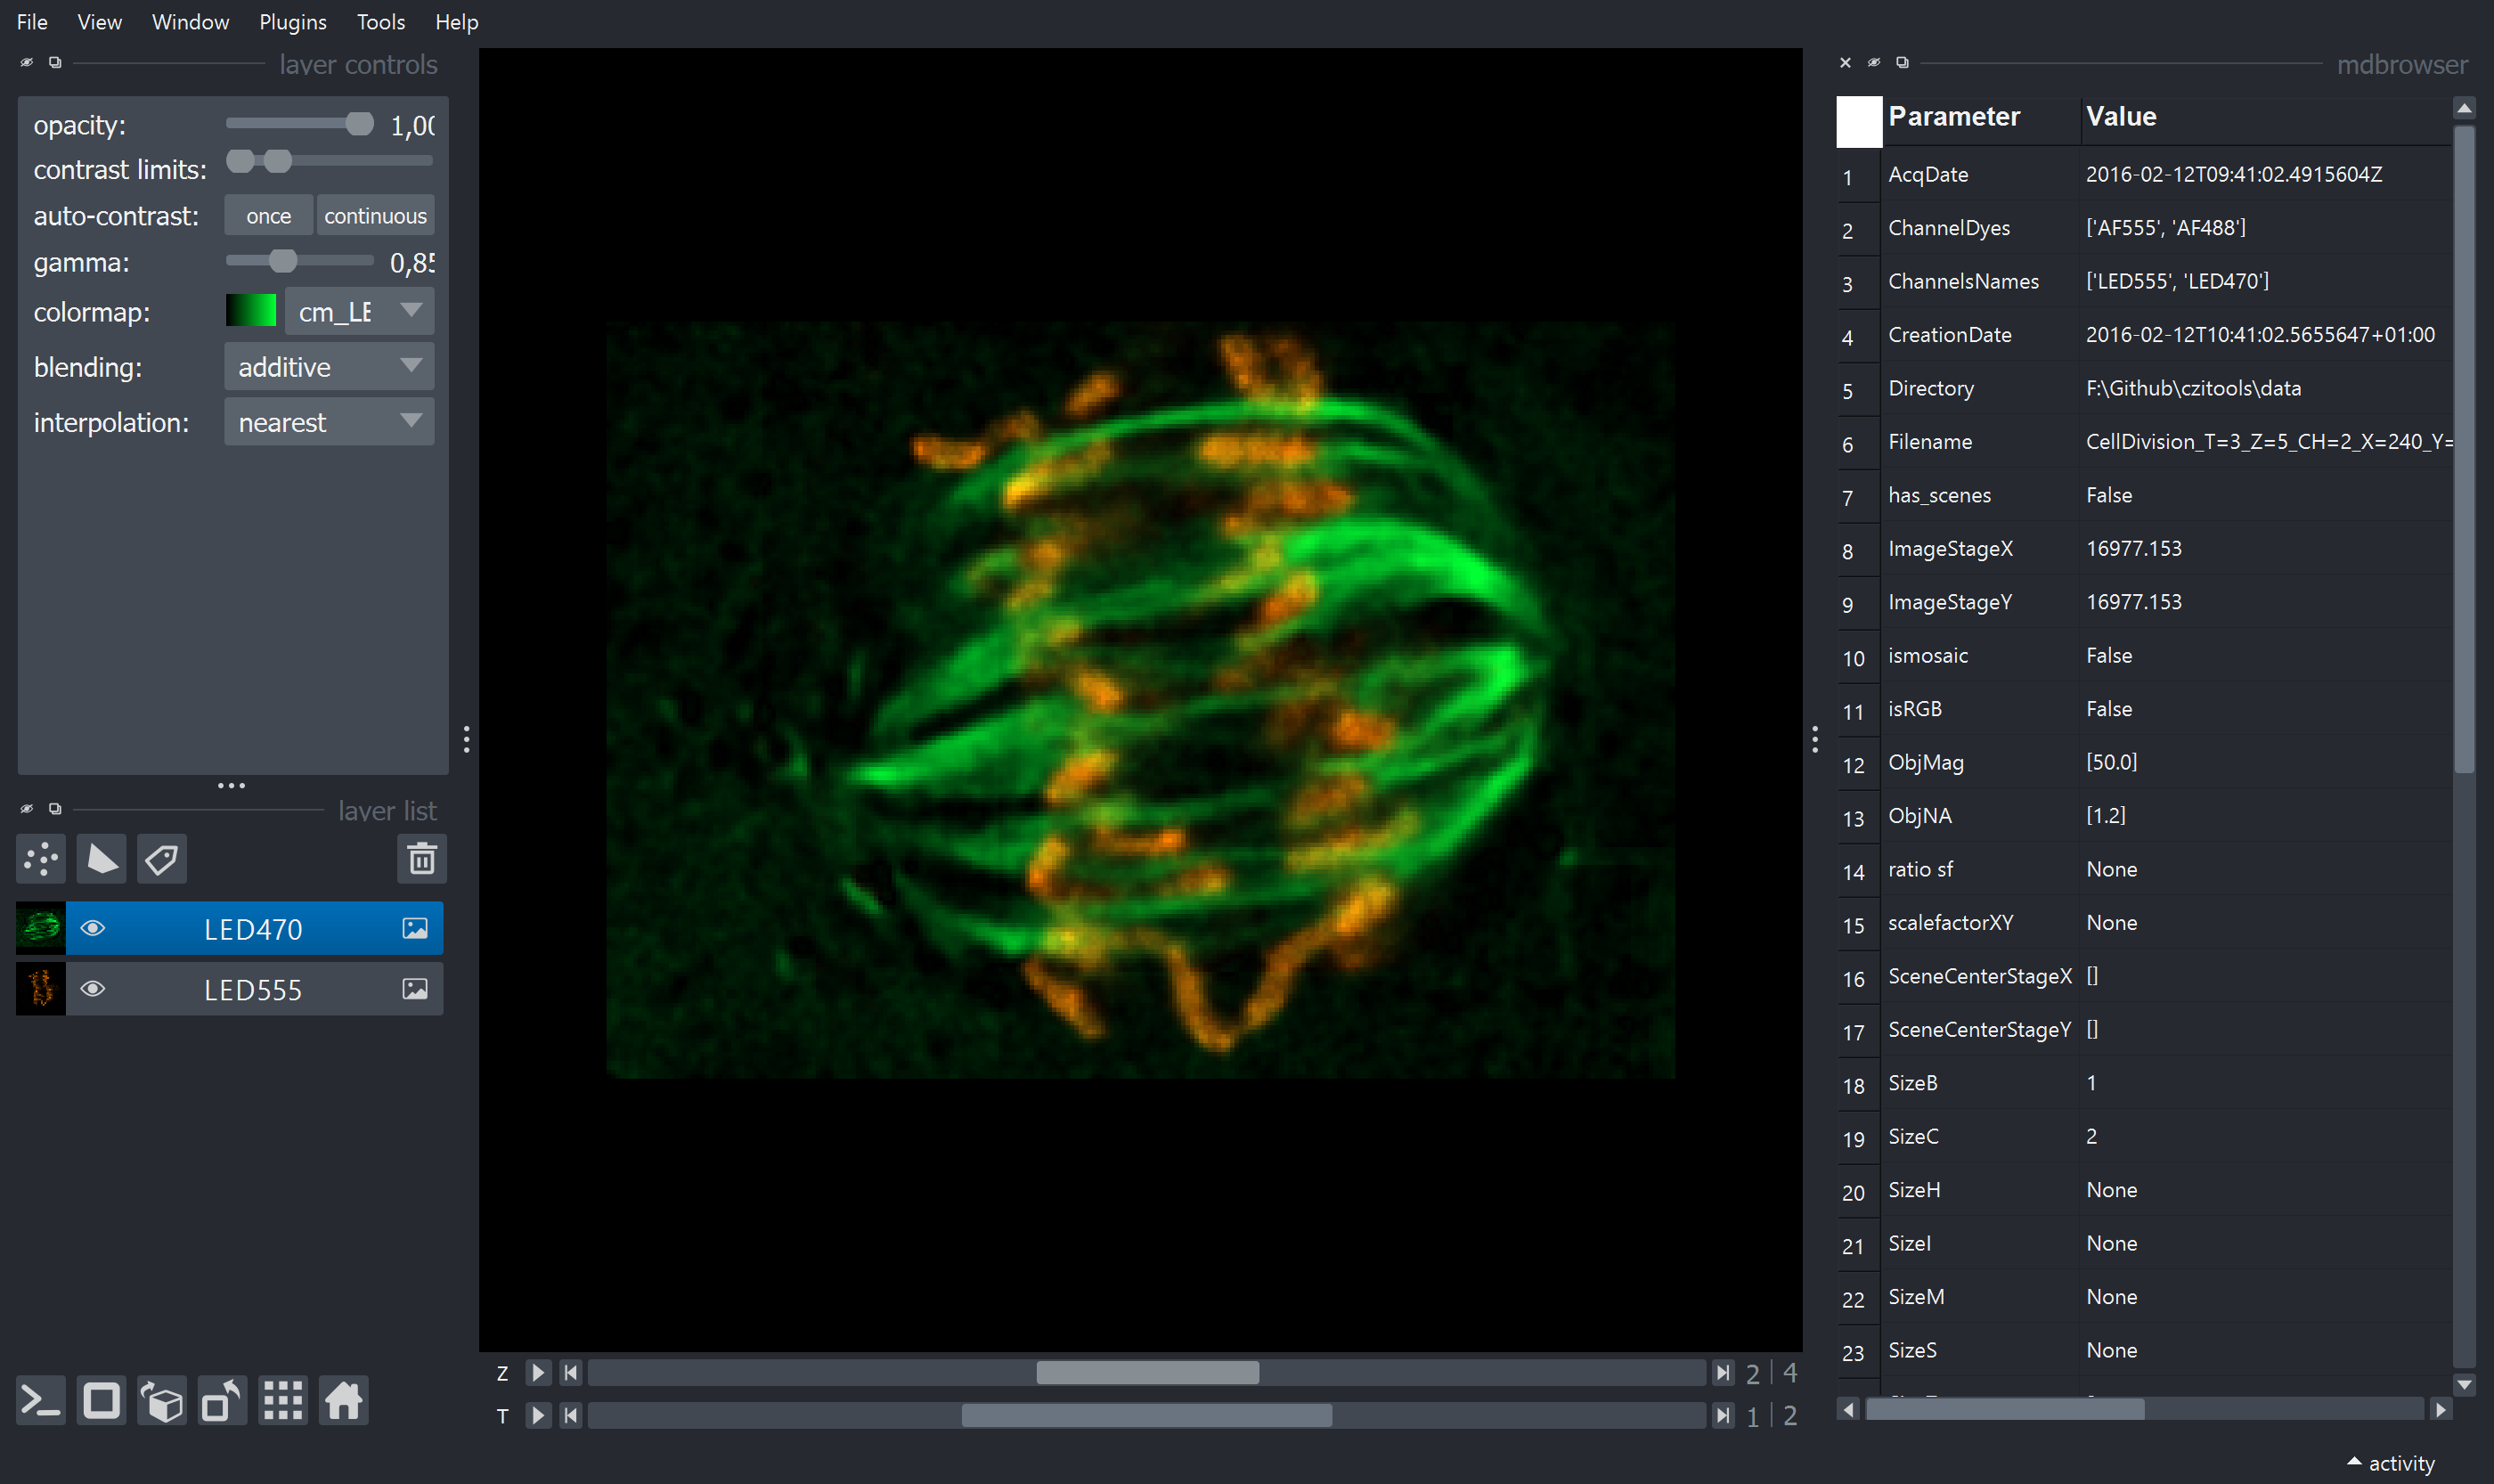

In [22]:
napari.utils.nbscreenshot(viewer)